In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
import cv2
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

In [2]:
from zipfile import ZipFile
file_name = "flowers.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
data_dir='./flowers'
data_dir=pathlib.Path(data_dir)
list_flower=list(data_dir.glob('*/*.jpg'))
image_count = len(list_flower)
print(image_count)

12847


In [4]:
batch_size = 32
img_height = 480
img_width = 480
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12847 files belonging to 13 classes.
Using 10278 files for training.


In [5]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12847 files belonging to 13 classes.
Using 2569 files for validation.


['astilbe', 'bellflower', 'black-eyed susan', 'calendula', 'california poppy', 'carnation', 'common daisy', 'coreopsis', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip']


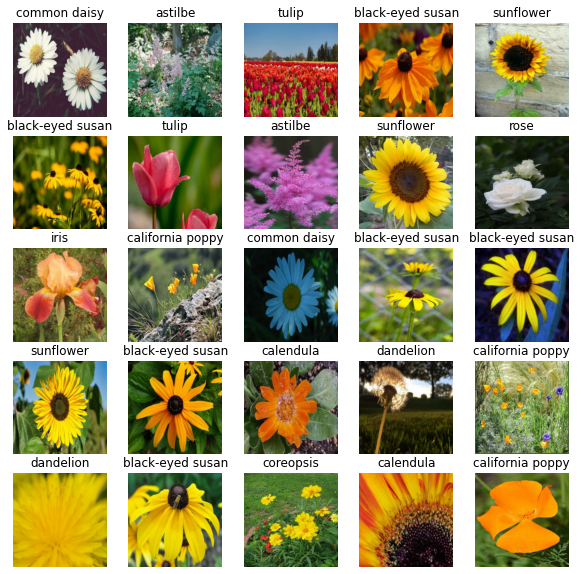

In [6]:
class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches)
validation_dataset = validation_ds.skip(val_batches//15)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 76
Number of test batches: 81


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
IMG_SHAPE = (img_height, img_width) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')   

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
base_model.summary()

(32, 15, 15, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 240, 240, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 240, 240, 32  128         ['Conv1[0][0]']                  
                                )                           

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(13)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 13)


In [13]:
inputs = tf.keras.Input(shape=(480, 480, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 480, 480, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 480, 480, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 15, 15, 1280)     2257984   
 ional)                                                          
                                                             

2

In [15]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

76/76 [==============================] - 33s 361ms/step - loss: 2.7323 - accuracy: 0.1054
initial loss: 2.73
initial accuracy: 0.11


In [16]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
322/322 [==============================] - 154s 464ms/step - loss: 1.0353 - accuracy: 0.7053 - val_loss: 0.5894 - val_accuracy: 0.8547
Epoch 2/5
322/322 [==============================] - 150s 463ms/step - loss: 0.5306 - accuracy: 0.8480 - val_loss: 0.4427 - val_accuracy: 0.8821
Epoch 3/5
322/322 [==============================] - 150s 464ms/step - loss: 0.4438 - accuracy: 0.8675 - val_loss: 0.3991 - val_accuracy: 0.8838
Epoch 4/5
322/322 [==============================] - 150s 463ms/step - loss: 0.3950 - accuracy: 0.8792 - val_loss: 0.3652 - val_accuracy: 0.8971
Epoch 5/5
322/322 [==============================] - 150s 463ms/step - loss: 0.3565 - accuracy: 0.8903 - val_loss: 0.3453 - val_accuracy: 0.8962


In [17]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 480, 480, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 480, 480, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 15, 15, 1280)     2257984   
 ional)                                                          
                    

107

In [18]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
322/322 [==============================] - 267s 797ms/step - loss: 0.6854 - accuracy: 0.7918 - val_loss: 0.3498 - val_accuracy: 0.8813
Epoch 6/10
322/322 [==============================] - 257s 795ms/step - loss: 0.3768 - accuracy: 0.8829 - val_loss: 0.5124 - val_accuracy: 0.8294
Epoch 7/10
322/322 [==============================] - 257s 795ms/step - loss: 0.2933 - accuracy: 0.9085 - val_loss: 0.2990 - val_accuracy: 0.8979
Epoch 8/10
322/322 [==============================] - 257s 796ms/step - loss: 0.2464 - accuracy: 0.9224 - val_loss: 0.7826 - val_accuracy: 0.7804
Epoch 9/10
322/322 [==============================] - 257s 797ms/step - loss: 0.2148 - accuracy: 0.9310 - val_loss: 0.6818 - val_accuracy: 0.8265
Epoch 10/10
322/322 [==============================] - 257s 795ms/step - loss: 0.1992 - accuracy: 0.9386 - val_loss: 0.2984 - val_accuracy: 0.9149


In [19]:
loss, accuracy = model.evaluate(test_dataset)
print(len(test_dataset))
print('Test accuracy :', accuracy)

81/81 [==============================] - 29s 350ms/step - loss: 0.2916 - accuracy: 0.9163
81
Test accuracy : 0.9163098335266113


In [20]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Number of layers in the base model:  154
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 480, 480, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 480, 480, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 15, 15, 1280)     2257984   
 ional)                                                          
                    

107

In [21]:
fine_tune_epochs = 3
total_epochs =   fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                  
                         validation_data=validation_dataset)

Epoch 1/3
322/322 [==============================] - 264s 795ms/step - loss: 0.0837 - accuracy: 0.9730 - val_loss: 0.1757 - val_accuracy: 0.9552
Epoch 2/3
322/322 [==============================] - 257s 796ms/step - loss: 0.0607 - accuracy: 0.9806 - val_loss: 0.1711 - val_accuracy: 0.9506
Epoch 3/3
322/322 [==============================] - 254s 786ms/step - loss: 0.0548 - accuracy: 0.9836 - val_loss: 0.1746 - val_accuracy: 0.9498


In [22]:
model.save('VXA200020_model.h5')

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print(len(test_dataset))
print('Test accuracy :', accuracy)

81/81 [==============================] - 29s 348ms/step - loss: 0.1705 - accuracy: 0.9506
81
Test accuracy : 0.950564444065094


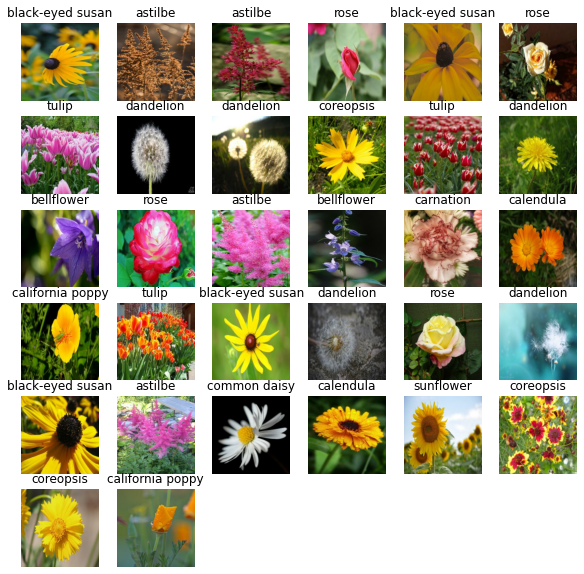

In [24]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
sol = np.zeros(len(predictions))
c=-1
for p in predictions:
  c=c+1
  m = max(p)
  for i in range(0,len(p)):
    if p[i] != m:
      p[i] =0
    else:
      p[i]=1 
      sol[c]=int(i) 

plt.figure(figsize=(10, 10))      
for i in range(len(sol)):
  ax = plt.subplot(len(sol)//5, len(sol)//5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[int(sol[i])])
  plt.axis("off")

In [25]:
model.test = tf.keras.models.load_model('VXA200020_model.h5')

In [26]:
loss, accuracy = model.test.evaluate(train_dataset)
print(len(train_dataset))
print('Train accuracy :', accuracy)

322/322 [==============================] - 115s 353ms/step - loss: 0.0501 - accuracy: 0.9822
322
Train accuracy : 0.9821949601173401


In [27]:
loss, accuracy = model.test.evaluate(test_dataset)
print(len(test_dataset))
print('Test accuracy :', accuracy)

81/81 [==============================] - 29s 350ms/step - loss: 0.1705 - accuracy: 0.9506
81
Test accuracy : 0.950564444065094
